# Get the Data

In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [476]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [477]:
MY_OPTIMIZER = "Adam"
MY_EPOCHS = 25
#MY_LEARNING_RATE = 0.1

# Get the Data

In [478]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(4302, 8)

In [479]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,4302.000000,4302.000000,4.302000e+03,4302.000000,4.302000e+03,4.302000e+03,4.302000e+03,4.302000e+03
mean,15077.420656,-0.990424,8.529671e-07,-0.000163,6.164475e-07,-1.994053e-07,-3.525164e-07,5.085951e-08
std,8707.988721,0.001019,3.209865e-03,0.000699,2.137216e-03,6.596556e-03,1.443063e-03,9.891317e-08
min,0.000000,-0.991665,-4.521035e-03,-0.001121,-3.245196e-03,-9.033096e-03,-2.050685e-03,-1.730357e-07
25%,7538.710750,-0.991455,-3.225498e-03,-0.000857,-1.975802e-03,-6.507502e-03,-1.456351e-03,-2.319600e-08
50%,15077.425000,-0.990587,1.051673e-06,-0.000213,2.510054e-07,-3.764976e-04,-2.211053e-07,3.250598e-08
75%,22616.127500,-0.989402,3.226142e-03,0.000527,1.980218e-03,6.442375e-03,1.454106e-03,1.172658e-07
max,30154.840000,-0.988842,4.520552e-03,0.000898,3.245292e-03,9.929594e-03,2.049619e-03,3.585011e-07


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [480]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)

# Prepare the Data for Machine Learning Algorithms

In [481]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers["dv_st"].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz,angle
0,-0.990182,0.004321,-0.000465,0.003244,-0.002665,-0.001851,0.000000
1,-0.989104,-0.002210,-0.001006,-0.001970,-0.007873,0.000886,0.892670
2,-0.991459,-0.003319,0.000537,-0.001307,0.006469,0.001700,1.785344
3,-0.991244,0.004022,0.000297,0.001999,0.004270,-0.001958,2.678010
4,-0.988908,0.001122,-0.001093,0.001023,-0.008749,-0.000446,0.511451


## Create a Train/Test Set

In [482]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(2580, 7)
(861, 7)
(861, 7)


,x,y,z,dx,dy,dz,angle
3619,-0.990638,0.004516,-0.000178,0.003011,-0.000067,-0.001974,0.034530
2488,-0.990552,0.004508,-0.000236,0.003085,-0.000584,-0.001971,3.019119
1940,-0.989530,0.003415,-0.000796,0.002875,-0.005906,-0.001382,0.258510
2340,-0.991607,0.002063,0.000762,0.000569,0.008684,-0.001101,2.456939
3929,-0.990007,-0.004149,-0.000546,-0.003226,-0.003562,0.001713,1.423640


In [483]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.36383929, 0.99958675, 0.46684884, 0.96388315, 0.47280692,
        0.01840629, 0.01129136],
       [0.39402636, 0.99871722, 0.43848401, 0.97533699, 0.44558051,
        0.01930811, 0.987251  ],
       [0.75612954, 0.8778044 , 0.16075677, 0.94294127, 0.16489459,
        0.16284499, 0.08453265],
       [0.02037273, 0.72831504, 0.93254659, 0.58763974, 0.93429176,
        0.23134923, 0.80341814],
       [0.58733702, 0.04113553, 0.28461863, 0.00292428, 0.28849762,
        0.91781887, 0.46552977]])

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [484]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 300)            │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,601 (127.35 KB)

 Trainable params: 32,601 (127.35 KB)

 Non-trainable params: 0 (0.00 B)

In [485]:
model.compile(loss="mean_squared_error", optimizer=MY_OPTIMIZER)
history = model.fit(X_train_scaled, y_train, epochs=MY_EPOCHS, 
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 8.3537e-04
Epoch 2/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3321e-04 - val_loss: 1.9579e-04
Epoch 3/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5744e-04 - val_loss: 8.1828e-05
Epoch 4/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6518e-05 - val_loss: 5.0877e-05
Epoch 5/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8831e-05 - val_loss: 3.8162e-05
Epoch 6/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9948e-05 - val_loss: 3.1392e-05
Epoch 7/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0495e-05 - val_loss: 2.7194e-05
Epoch 8/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6698e-05 - val_loss: 2.3948e-05
Epoch 9/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4194e-05 - val_loss: 2.1568e-05
Epoch 10/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2962e-05 - val_loss: 1.9613e-05
Epoch 11/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9295e-05 - 

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7460e-06 - val_loss: 3.3011e-06
Epoch 66/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5438e-06 - val_loss: 3.2653e-06
Epoch 67/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2879e-06 - val_loss: 3.2356e-06
Epoch 68/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4131e-06 - val_loss: 3.2001e-06
Epoch 69/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7641e-06 - val_loss: 3.1606e-06
Epoch 70/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5395e-06 - val_loss: 3.1358e-06
Epoch 71/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7233e-06 - val_loss: 3.0961e-06
Epoch 72/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5793e-06 - val_loss: 3.0741e-06
Epoch 73/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0741e-06 - val_loss: 3.0348e-06
Epoch 74/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1817e-06 - val_loss: 3.0081e-06
Epoch 75/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9020e-06 - 

Epoch 129/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9437e-06 - val_loss: 2.0897e-06
Epoch 130/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0920e-06 - val_loss: 2.0634e-06
Epoch 131/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2389e-06 - val_loss: 2.0423e-06
Epoch 132/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9638e-06 - val_loss: 2.0503e-06
Epoch 133/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1778e-06 - val_loss: 2.0209e-06
Epoch 134/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1266e-06 - val_loss: 2.0200e-06
Epoch 135/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8599e-06 - val_loss: 2.0091e-06
Epoch 136/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0168e-06 - val_loss: 1.9953e-06
Epoch 137/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9186e-06 - val_loss: 1.9845e-06
Epoch 138/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9887e-06 - val_loss: 1.9788e-06
Epoch 139/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5872e-06 - val_loss: 1.5796e-06
Epoch 193/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4699e-06 - val_loss: 1.5764e-06
Epoch 194/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5005e-06 - val_loss: 1.5739e-06
Epoch 195/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3632e-06 - val_loss: 1.5697e-06
Epoch 196/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4286e-06 - val_loss: 1.5615e-06
Epoch 197/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5301e-06 - val_loss: 1.5515e-06
Epoch 198/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5882e-06 - val_loss: 1.5446e-06
Epoch 199/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5020e-06 - val_loss: 1.5388e-06
Epoch 200/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4802e-06 - val_loss: 1.5520e-06
Epoch 201/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5203e-06 - val_loss: 1.5335e-06
Epoch 202/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2232e-06 - val_loss: 1.2862e-06
Epoch 256/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2712e-06 - val_loss: 1.2814e-06
Epoch 257/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2163e-06 - val_loss: 1.2819e-06
Epoch 258/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1996e-06 - val_loss: 1.2837e-06
Epoch 259/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1771e-06 - val_loss: 1.2716e-06
Epoch 260/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 1.1371e-06 - val_loss: 1.2677e-06
Epoch 261/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1812e-06 - val_loss: 1.2647e-06
Epoch 262/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1360e-06 - val_loss: 1.2627e-06
Epoch 263/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1449e-06 - val_loss: 1.2645e-06
Epoch 264/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1948e-06 - val_loss: 1.2553e-06
Epoch 265/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0039e-06 - val_loss: 1.0870e-06
Epoch 319/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7362e-07 - val_loss: 1.0846e-06
Epoch 320/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0634e-06 - val_loss: 1.0820e-06
Epoch 321/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0149e-06 - val_loss: 1.0815e-06
Epoch 322/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0492e-06 - val_loss: 1.0766e-06
Epoch 323/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3930e-07 - val_loss: 1.0727e-06
Epoch 324/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4594e-07 - val_loss: 1.0700e-06
Epoch 325/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0346e-06 - val_loss: 1.0681e-06
Epoch 326/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5842e-07 - val_loss: 1.0651e-06
Epoch 327/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6206e-07 - val_loss: 1.0641e-06
Epoch 328/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1878e-07 - val_loss: 9.4508e-07
Epoch 382/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0382e-07 - val_loss: 9.4336e-07
Epoch 383/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6231e-07 - val_loss: 9.4251e-07
Epoch 384/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4542e-07 - val_loss: 9.3927e-07
Epoch 385/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3200e-07 - val_loss: 9.4148e-07
Epoch 386/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0735e-07 - val_loss: 9.4286e-07
Epoch 387/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0084e-07 - val_loss: 9.3317e-07
Epoch 388/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4459e-07 - val_loss: 9.3183e-07
Epoch 389/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8693e-07 - val_loss: 9.3470e-07
Epoch 390/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2209e-07 - val_loss: 9.2956e-07
Epoch 391/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1

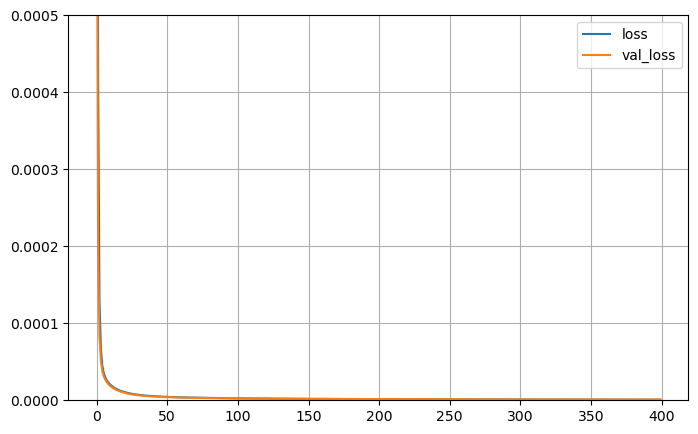

In [486]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [487]:
mse_test = model.evaluate(X_test_scaled, y_test)
np.sqrt(mse_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 8.8382e-07


0.0009106258037834069

In [488]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [489]:
y_test[:3]

748     6.582550e-08
90      9.909022e-08
3735    1.656921e-08
Name: dv_st, dtype: float64

In [490]:
y_pred[:3]

array([[-0.00158797],
       [-0.00161233],
       [-0.00019164]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [491]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model


In [492]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [493]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [494]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [495]:
tuner.search(X_train_scaled, y_train, epochs=MY_EPOCHS, validation_data=(X_valid_scaled, y_valid))

Trial 2 Complete [00h 01m 48s]
val_loss: 1.0641588374937783e-06

Best val_loss So Far: 1.0641588374937783e-06
Total elapsed time: 00h 03m 15s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
5                 |3                 |num_layers
96                |128               |units_0
224               |480               |units_1
448               |32                |units_2

Epoch 1/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7553e-05 - val_loss: 2.6102e-05
Epoch 2/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1296e-05 - val_loss: 1.8634e-05
Epoch 3/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5503e-05 - val_loss: 1.5077e-05
Epoch 4/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2692e-05 - val_loss: 1.3012e-05
Epoch 5/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0669e-05 - val_loss: 1.1490e-05
Epoch 6/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3959e-06 - val_loss: 1.0211e-05
Epoch 7/400
81/81 ━━━━━━━━━━━━━━

Epoch 62/400
41/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4154e-06 

KeyboardInterrupt: 

## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
tuner.results_summary()

In [ ]:
mse_test = best_model.evaluate(X_test_scaled, y_test)
np.sqrt(mse_test)

In [ ]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = best_model.predict(X_new)

In [ ]:
y_test[:3]

In [ ]:
y_pred[:3]